In [2]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange
import pdb

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# x_train = np.transpose(x_train, [0, 3,1,2])
# x_test = np.transpose(x_test, [0, 3,1,2])



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

print(np.min(x_train),np.max(x_train))
print(np.min(x_test),np.max(x_test))

# Model from: https://github.com/kuangliu/pytorch-cifar
# MIT License
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet_18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model, test_loader, max_steps=10):
#     pdb.set_trace()
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
#             print(accuracy)
    
#     # compute the accuracy over all test images
#     print(accuracy)
    accuracy = (100 * accuracy / total)
    if model_was_training:
        model.train()
    return(accuracy)

def create_model(x_train, y_train, x_test=None, y_test=None, num_classes=10, batch_size=128, epochs=25, x_trigger=None, y_trigger=None):
#     if x_test==None or y_test==None:
#         x_test = x_train
#         y_test = y_train
#     pdb.set_trace() 
    model = resnet_18()

    if x_trigger is not None:
        assert(x_trigger.shape[0] == 1)
        x_trigger = torch.tensor(x_trigger, dtype=torch.float32, device=device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    model.to(device)

    y_train = np.argmax(y_train, axis=1)
    x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    dataset_train = TensorDataset(x_tensor,y_tensor) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_tensor_test,y_tensor_test) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)
    iter = trange(epochs)
    for _ in iter:
        running_loss = 0.0
        total = 0
        accuracy = 0
        for _, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (accuracy / total)
        if x_trigger is not None:
            y_ = model(x_trigger)
            y_ = F.softmax(y_, dim=-1)[0]
            output_target = y_.detach().cpu().numpy()[y_trigger]
            iter.set_postfix({'acc': train_accuracy, 'target': output_target})
            tqdm.tqdm.write(str(output_target))
        else:
            iter.set_postfix({'acc': train_accuracy})
        test_accuracy = testAccuracy(model, dataloader_test)
        print("Final test accuracy: %f" % test_accuracy)

    del x_tensor, y_tensor
    del x_tensor_test, y_tensor_test
    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model, loss_fn, optimizer

model, loss_fn, optimizer = create_model(x_train, y_train,x_test,y_test, epochs=80)
model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)

print("Model and data preparation done.")

-1.8816426241908337 2.0934095498544254
-1.8816426241908337 2.0934095498544254


  1%|▎                         | 1/80 [00:15<20:17, 15.41s/it, acc=0.4]

Final test accuracy: 48.510000


  2%|▌                       | 2/80 [00:30<20:02, 15.42s/it, acc=0.605]

Final test accuracy: 66.250000


  4%|▉                       | 3/80 [00:46<19:47, 15.42s/it, acc=0.706]

Final test accuracy: 69.810000


  5%|█▏                      | 4/80 [01:01<19:33, 15.44s/it, acc=0.767]

Final test accuracy: 73.000000


  6%|█▌                      | 5/80 [01:17<19:18, 15.45s/it, acc=0.814]

Final test accuracy: 72.730000


  8%|█▊                      | 6/80 [01:32<19:03, 15.45s/it, acc=0.847]

Final test accuracy: 69.350000


  9%|██▏                      | 7/80 [01:48<18:47, 15.45s/it, acc=0.87]

Final test accuracy: 74.260000


 10%|██▍                     | 8/80 [02:03<18:31, 15.44s/it, acc=0.887]

Final test accuracy: 74.230000


 11%|██▋                     | 9/80 [02:18<18:15, 15.44s/it, acc=0.903]

Final test accuracy: 72.750000


 12%|███                     | 10/80 [02:34<18:00, 15.44s/it, acc=0.91]

Final test accuracy: 71.430000


 14%|███▏                   | 11/80 [02:49<17:45, 15.44s/it, acc=0.917]

Final test accuracy: 73.000000


 15%|███▍                   | 12/80 [03:05<17:29, 15.43s/it, acc=0.923]

Final test accuracy: 75.010000


 16%|███▋                   | 13/80 [03:20<17:13, 15.43s/it, acc=0.927]

Final test accuracy: 74.690000


 18%|████▏                   | 14/80 [03:36<16:58, 15.43s/it, acc=0.93]

Final test accuracy: 76.410000


 19%|████▎                  | 15/80 [03:51<16:42, 15.42s/it, acc=0.933]

Final test accuracy: 77.970000


 20%|████▌                  | 16/80 [04:06<16:27, 15.42s/it, acc=0.935]

Final test accuracy: 75.440000


 21%|████▉                  | 17/80 [04:22<16:11, 15.42s/it, acc=0.936]

Final test accuracy: 69.840000


 22%|█████▏                 | 18/80 [04:37<15:56, 15.42s/it, acc=0.938]

Final test accuracy: 77.650000


 24%|█████▍                 | 19/80 [04:53<15:40, 15.42s/it, acc=0.941]

Final test accuracy: 76.870000


 25%|██████                  | 20/80 [05:08<15:25, 15.42s/it, acc=0.94]

Final test accuracy: 76.750000


 26%|██████                 | 21/80 [05:23<15:09, 15.41s/it, acc=0.941]

Final test accuracy: 75.960000


 28%|██████▎                | 22/80 [05:39<14:53, 15.41s/it, acc=0.944]

Final test accuracy: 74.230000


 29%|██████▌                | 23/80 [05:54<14:38, 15.41s/it, acc=0.942]

Final test accuracy: 74.210000


 30%|██████▉                | 24/80 [06:10<14:23, 15.41s/it, acc=0.942]

Final test accuracy: 76.870000


 31%|███████▏               | 25/80 [06:25<14:07, 15.41s/it, acc=0.945]

Final test accuracy: 77.690000


 32%|███████▍               | 26/80 [06:41<13:52, 15.42s/it, acc=0.944]

Final test accuracy: 76.370000


 34%|███████▊               | 27/80 [06:56<13:37, 15.42s/it, acc=0.944]

Final test accuracy: 78.940000


 35%|████████               | 28/80 [07:11<13:21, 15.42s/it, acc=0.945]

Final test accuracy: 78.730000


 36%|████████▎              | 29/80 [07:27<13:06, 15.42s/it, acc=0.947]

Final test accuracy: 77.690000


 38%|████████▋              | 30/80 [07:42<12:50, 15.42s/it, acc=0.944]

Final test accuracy: 78.750000


 39%|████████▉              | 31/80 [07:58<12:35, 15.42s/it, acc=0.948]

Final test accuracy: 78.640000


 40%|█████████▏             | 32/80 [08:13<12:19, 15.41s/it, acc=0.945]

Final test accuracy: 77.670000


 41%|█████████▍             | 33/80 [08:28<12:04, 15.41s/it, acc=0.948]

Final test accuracy: 72.430000


 42%|█████████▊             | 34/80 [08:44<11:48, 15.40s/it, acc=0.947]

Final test accuracy: 77.110000


 44%|██████████             | 35/80 [08:59<11:33, 15.40s/it, acc=0.946]

Final test accuracy: 75.220000


 45%|██████████▎            | 36/80 [09:15<11:17, 15.40s/it, acc=0.949]

Final test accuracy: 74.980000


 46%|██████████▋            | 37/80 [09:30<11:02, 15.40s/it, acc=0.947]

Final test accuracy: 77.950000


 48%|██████████▉            | 38/80 [09:45<10:46, 15.40s/it, acc=0.948]

Final test accuracy: 78.210000


 49%|███████████▏           | 39/80 [10:01<10:31, 15.40s/it, acc=0.947]

Final test accuracy: 78.350000


 50%|███████████▌           | 40/80 [10:16<10:15, 15.40s/it, acc=0.947]

Final test accuracy: 74.000000


 51%|███████████▊           | 41/80 [10:32<10:00, 15.39s/it, acc=0.951]

Final test accuracy: 78.570000


 52%|████████████           | 42/80 [10:47<09:45, 15.40s/it, acc=0.948]

Final test accuracy: 76.880000


 54%|████████████▉           | 43/80 [11:02<09:29, 15.39s/it, acc=0.95]

Final test accuracy: 77.000000


 55%|████████████▋          | 44/80 [11:18<09:14, 15.39s/it, acc=0.949]

Final test accuracy: 79.720000


 56%|████████████▉          | 45/80 [11:33<08:58, 15.39s/it, acc=0.951]

Final test accuracy: 79.510000


 57%|█████████████▏         | 46/80 [11:49<08:43, 15.39s/it, acc=0.951]

Final test accuracy: 79.840000


 59%|█████████████▌         | 47/80 [12:04<08:27, 15.39s/it, acc=0.948]

Final test accuracy: 74.040000


 60%|█████████████▊         | 48/80 [12:19<08:12, 15.39s/it, acc=0.949]

Final test accuracy: 79.650000


 61%|██████████████         | 49/80 [12:35<07:57, 15.39s/it, acc=0.954]

Final test accuracy: 77.240000


 62%|██████████████▍        | 50/80 [12:50<07:41, 15.40s/it, acc=0.949]

Final test accuracy: 79.230000


 64%|██████████████▋        | 51/80 [13:06<07:26, 15.40s/it, acc=0.951]

Final test accuracy: 79.790000


 65%|██████████████▉        | 52/80 [13:21<07:11, 15.40s/it, acc=0.949]

Final test accuracy: 79.940000


 66%|███████████████▏       | 53/80 [13:36<06:55, 15.40s/it, acc=0.951]

Final test accuracy: 79.880000


 68%|███████████████▌       | 54/80 [13:52<06:40, 15.40s/it, acc=0.952]

Final test accuracy: 78.890000


 69%|███████████████▊       | 55/80 [14:07<06:24, 15.40s/it, acc=0.951]

Final test accuracy: 76.810000


 70%|████████████████       | 56/80 [14:23<06:09, 15.40s/it, acc=0.951]

Final test accuracy: 78.080000


 71%|████████████████▍      | 57/80 [14:38<05:54, 15.40s/it, acc=0.951]

Final test accuracy: 77.600000


 72%|████████████████▋      | 58/80 [14:53<05:38, 15.40s/it, acc=0.952]

Final test accuracy: 74.510000


 74%|████████████████▉      | 59/80 [15:09<05:23, 15.39s/it, acc=0.948]

Final test accuracy: 78.040000


 75%|█████████████████▎     | 60/80 [15:24<05:07, 15.39s/it, acc=0.953]

Final test accuracy: 78.920000


 76%|█████████████████▌     | 61/80 [15:40<04:52, 15.39s/it, acc=0.952]

Final test accuracy: 79.170000


 78%|█████████████████▊     | 62/80 [15:55<04:37, 15.39s/it, acc=0.951]

Final test accuracy: 77.030000


 79%|██████████████████     | 63/80 [16:10<04:21, 15.39s/it, acc=0.951]

Final test accuracy: 78.450000


 80%|██████████████████▍    | 64/80 [16:26<04:06, 15.39s/it, acc=0.951]

Final test accuracy: 80.040000


 81%|██████████████████▋    | 65/80 [16:41<03:50, 15.40s/it, acc=0.951]

Final test accuracy: 80.720000


 82%|██████████████████▉    | 66/80 [16:57<03:35, 15.40s/it, acc=0.954]

Final test accuracy: 81.180000


 84%|███████████████████▎   | 67/80 [17:12<03:20, 15.40s/it, acc=0.951]

Final test accuracy: 80.760000


 85%|███████████████████▌   | 68/80 [17:27<03:04, 15.40s/it, acc=0.952]

Final test accuracy: 77.130000


 86%|███████████████████▊   | 69/80 [17:43<02:49, 15.40s/it, acc=0.953]

Final test accuracy: 77.260000


 88%|████████████████████▏  | 70/80 [17:58<02:33, 15.39s/it, acc=0.953]

Final test accuracy: 79.600000


 89%|████████████████████▍  | 71/80 [18:13<02:18, 15.40s/it, acc=0.953]

Final test accuracy: 79.660000


 90%|████████████████████▋  | 72/80 [18:29<02:03, 15.39s/it, acc=0.952]

Final test accuracy: 80.570000


 91%|████████████████████▉  | 73/80 [18:44<01:47, 15.39s/it, acc=0.953]

Final test accuracy: 74.130000


 92%|█████████████████████▎ | 74/80 [19:00<01:32, 15.39s/it, acc=0.949]

Final test accuracy: 77.600000


 94%|█████████████████████▌ | 75/80 [19:15<01:16, 15.40s/it, acc=0.952]

Final test accuracy: 73.900000


 95%|█████████████████████▊ | 76/80 [19:30<01:01, 15.40s/it, acc=0.953]

Final test accuracy: 79.120000


 96%|██████████████████████▏| 77/80 [19:46<00:46, 15.40s/it, acc=0.952]

Final test accuracy: 79.990000


 98%|██████████████████████▍| 78/80 [20:01<00:30, 15.39s/it, acc=0.956]

Final test accuracy: 79.540000


 99%|██████████████████████▋| 79/80 [20:17<00:15, 15.39s/it, acc=0.951]

Final test accuracy: 78.560000


100%|███████████████████████| 80/80 [20:32<00:00, 15.41s/it, acc=0.952]

Final test accuracy: 78.690000
Model and data preparation done.


In [15]:
print(mean.shape)

()


In [ ]:
# torch.save(model.state_dict(),'sleeper-model.pt')

In [ ]:
# model, loss_fn, optimizer = create_model(x_train, y_train, epochs=0)
# model.load_state_dict(torch.load('sleeper-model.pt'))
# model_art = PyTorchClassifier(model, input_shape=x_train.shape[1:], loss=loss_fn, optimizer=optimizer, nb_classes=10)
# model

# Apply patches to images

In [3]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
patch = np.transpose(resize(numpydata, (8,8,3)),(2,0,1))
patch = (patch-mean)/(std+1e-7)
print(np.min(patch),np.max(patch))



K = 1000 # Number of samples to be taken from train images

# A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
indices_target = np.where(y_train.argmax(axis=1)==class_source)[0][0:K]
x_trigger = x_train[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

(80, 80, 3)
-1.877938567753497 2.0934095498544254
(1000, 3, 32, 32)
shape of patch (3, 8, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


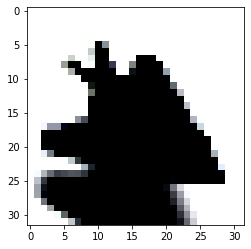

In [4]:
plt.imshow(x_train[indices_target[0]].transpose([1,2,0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


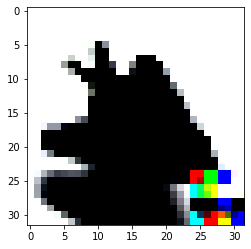

In [5]:
plt.imshow(x_trigger[0].transpose([1,2,0]))

# Generate Poisons

In [6]:
print(max_,min_)

2.0934095498544254 -1.8816426241908337


In [8]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

factor = 16/255
epsilson = factor * (max_-min_)
print(epsilson)
attack = GradientMatchingAttack(model_art,
        percent_poison=0.10,
        max_trials=1,
        max_epochs=500,
        clip_values=(min_,max_),
        learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),                         
        epsilon=epsilson,
        verbose=1)

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)

0.24941503837146722


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.021626099944114685
Best B-score: 0.021626099944114685


# Examples of the trigger, an original sample, and the poisoned sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


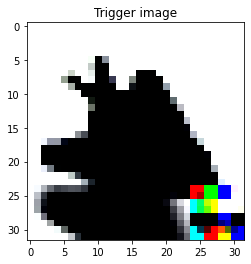

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


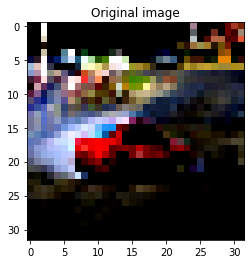

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


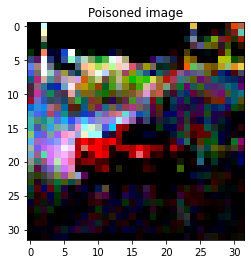

In [9]:
import matplotlib.pyplot as plt
# plt.imshow(x_trigger[0].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_trigger[0].transpose([1,2,0]))
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
# plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_train[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Original image')
plt.show()

# plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0])*(std+1e-7)+mean)
plt.imshow(x_poison[index_poisoned_example[0]].transpose([1,2,0]))
plt.title('Poisoned image')
plt.show()

# Training with Poison Images
These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [15]:
model_poisoned = create_model(x_poison, y_poison,x_test,y_test,epochs=200)

  0%|                       | 1/200 [00:15<50:51, 15.33s/it, acc=0.318]

Final test accuracy: 44.550000


  1%|▏                      | 2/200 [00:30<50:35, 15.33s/it, acc=0.517]

Final test accuracy: 59.160000


  2%|▎                      | 3/200 [00:45<50:20, 15.33s/it, acc=0.636]

Final test accuracy: 66.040000


  2%|▍                      | 4/200 [01:01<50:04, 15.33s/it, acc=0.711]

Final test accuracy: 71.750000


  2%|▌                      | 5/200 [01:16<49:49, 15.33s/it, acc=0.769]

Final test accuracy: 72.810000


  3%|▋                      | 6/200 [01:31<49:34, 15.33s/it, acc=0.816]

Final test accuracy: 74.100000


  4%|▊                      | 7/200 [01:47<49:18, 15.33s/it, acc=0.849]

Final test accuracy: 73.760000


  4%|▉                      | 8/200 [02:02<49:03, 15.33s/it, acc=0.868]

Final test accuracy: 74.090000


  4%|█                      | 9/200 [02:17<48:48, 15.33s/it, acc=0.883]

Final test accuracy: 72.990000


  5%|█                     | 10/200 [02:33<48:32, 15.33s/it, acc=0.899]

Final test accuracy: 75.070000


  6%|█▏                    | 11/200 [02:48<48:17, 15.33s/it, acc=0.906]

Final test accuracy: 70.200000


  6%|█▎                    | 12/200 [03:03<48:01, 15.33s/it, acc=0.915]

Final test accuracy: 74.620000


  6%|█▍                     | 13/200 [03:19<47:46, 15.33s/it, acc=0.92]

Final test accuracy: 73.740000


  7%|█▌                    | 14/200 [03:34<47:31, 15.33s/it, acc=0.928]

Final test accuracy: 76.100000


  8%|█▋                    | 15/200 [03:49<47:16, 15.33s/it, acc=0.928]

Final test accuracy: 74.110000


  8%|█▊                    | 16/200 [04:05<47:01, 15.33s/it, acc=0.934]

Final test accuracy: 71.910000


  8%|█▊                    | 17/200 [04:20<46:45, 15.33s/it, acc=0.934]

Final test accuracy: 76.420000


  9%|█▉                    | 18/200 [04:35<46:30, 15.33s/it, acc=0.936]

Final test accuracy: 77.150000


 10%|██                    | 19/200 [04:51<46:15, 15.33s/it, acc=0.935]

Final test accuracy: 74.910000


 10%|██▏                   | 20/200 [05:06<45:59, 15.33s/it, acc=0.938]

Final test accuracy: 75.980000


 10%|██▎                   | 21/200 [05:21<45:44, 15.33s/it, acc=0.937]

Final test accuracy: 74.460000


 11%|██▍                   | 22/200 [05:37<45:28, 15.33s/it, acc=0.941]

Final test accuracy: 77.540000


 12%|██▌                   | 23/200 [05:52<45:13, 15.33s/it, acc=0.942]

Final test accuracy: 77.330000


 12%|██▊                    | 24/200 [06:07<44:57, 15.33s/it, acc=0.94]

Final test accuracy: 76.960000


 12%|██▊                   | 25/200 [06:23<44:42, 15.33s/it, acc=0.943]

Final test accuracy: 79.070000


 13%|██▊                   | 26/200 [06:38<44:27, 15.33s/it, acc=0.943]

Final test accuracy: 78.100000


 14%|██▉                   | 27/200 [06:53<44:11, 15.33s/it, acc=0.944]

Final test accuracy: 78.490000


 14%|███                   | 28/200 [07:09<43:56, 15.33s/it, acc=0.942]

Final test accuracy: 77.570000


 14%|███▏                  | 29/200 [07:24<43:41, 15.33s/it, acc=0.943]

Final test accuracy: 77.220000


 15%|███▎                  | 30/200 [07:39<43:26, 15.33s/it, acc=0.944]

Final test accuracy: 78.120000


 16%|███▍                  | 31/200 [07:55<43:10, 15.33s/it, acc=0.946]

Final test accuracy: 76.760000


 16%|███▌                  | 32/200 [08:10<42:55, 15.33s/it, acc=0.943]

Final test accuracy: 78.560000


 16%|███▋                  | 33/200 [08:25<42:40, 15.33s/it, acc=0.948]

Final test accuracy: 75.730000


 17%|███▋                  | 34/200 [08:41<42:24, 15.33s/it, acc=0.948]

Final test accuracy: 77.140000


 18%|███▊                  | 35/200 [08:56<42:09, 15.33s/it, acc=0.947]

Final test accuracy: 77.670000


 18%|███▉                  | 36/200 [09:11<41:54, 15.33s/it, acc=0.945]

Final test accuracy: 80.010000


 18%|████                  | 37/200 [09:27<41:39, 15.33s/it, acc=0.947]

Final test accuracy: 80.170000


 19%|████▏                 | 38/200 [09:42<41:23, 15.33s/it, acc=0.948]

Final test accuracy: 79.270000


 20%|████▎                 | 39/200 [09:57<41:08, 15.33s/it, acc=0.949]

Final test accuracy: 79.200000


 20%|████▍                 | 40/200 [10:13<40:52, 15.33s/it, acc=0.949]

Final test accuracy: 78.750000


 20%|████▌                 | 41/200 [10:28<40:37, 15.33s/it, acc=0.949]

Final test accuracy: 77.730000


 21%|████▌                 | 42/200 [10:43<40:22, 15.33s/it, acc=0.946]

Final test accuracy: 75.110000


 22%|████▋                 | 43/200 [10:59<40:07, 15.33s/it, acc=0.949]

Final test accuracy: 76.660000


 22%|█████                  | 44/200 [11:14<39:51, 15.33s/it, acc=0.95]

Final test accuracy: 79.600000


 22%|████▉                 | 45/200 [11:29<39:36, 15.33s/it, acc=0.948]

Final test accuracy: 76.820000


 23%|█████                 | 46/200 [11:45<39:21, 15.33s/it, acc=0.949]

Final test accuracy: 76.430000


 24%|█████▏                | 47/200 [12:00<39:06, 15.33s/it, acc=0.948]

Final test accuracy: 79.900000


 24%|█████▎                | 48/200 [12:15<38:50, 15.33s/it, acc=0.949]

Final test accuracy: 80.010000


 24%|█████▍                | 49/200 [12:31<38:35, 15.33s/it, acc=0.952]

Final test accuracy: 75.400000


 25%|█████▌                | 50/200 [12:49<40:44, 16.30s/it, acc=0.949]

Final test accuracy: 79.940000


 26%|█████▌                | 51/200 [13:23<53:39, 21.60s/it, acc=0.951]

Final test accuracy: 80.070000


 26%|█████▏              | 52/200 [13:55<1:00:32, 24.55s/it, acc=0.951]

Final test accuracy: 76.650000


 26%|█████▊                | 53/200 [14:10<53:22, 21.78s/it, acc=0.946]

Final test accuracy: 76.870000


 27%|█████▉                | 54/200 [14:36<55:54, 22.97s/it, acc=0.953]

Final test accuracy: 78.490000


 28%|██████                | 55/200 [15:03<58:36, 24.25s/it, acc=0.951]

Final test accuracy: 79.360000


 28%|██████▍                | 56/200 [15:26<57:38, 24.02s/it, acc=0.95]

Final test accuracy: 79.130000


 28%|██████▎               | 57/200 [15:45<52:58, 22.23s/it, acc=0.951]

Final test accuracy: 77.780000


 29%|██████▋                | 58/200 [16:03<49:38, 20.97s/it, acc=0.95]

Final test accuracy: 77.770000


 30%|██████▍               | 59/200 [16:19<46:02, 19.59s/it, acc=0.954]

Final test accuracy: 78.150000


 30%|██████▌               | 60/200 [16:34<42:44, 18.32s/it, acc=0.948]

Final test accuracy: 76.740000


 30%|██████▋               | 61/200 [16:50<40:22, 17.43s/it, acc=0.952]

Final test accuracy: 76.950000


 31%|██████▊               | 62/200 [17:05<38:38, 16.80s/it, acc=0.952]

Final test accuracy: 80.660000


 32%|██████▉               | 63/200 [17:20<37:21, 16.36s/it, acc=0.951]

Final test accuracy: 80.070000


 32%|███████               | 64/200 [17:36<36:23, 16.06s/it, acc=0.952]

Final test accuracy: 76.750000


 32%|███████▏              | 65/200 [17:51<35:38, 15.84s/it, acc=0.953]

Final test accuracy: 76.840000


 33%|███████▎              | 66/200 [18:06<35:02, 15.69s/it, acc=0.953]

Final test accuracy: 76.700000


 34%|███████▎              | 67/200 [18:22<34:32, 15.59s/it, acc=0.951]

Final test accuracy: 75.930000


 34%|███████▍              | 68/200 [18:37<34:07, 15.51s/it, acc=0.953]

Final test accuracy: 78.520000


 34%|███████▌              | 69/200 [18:52<33:45, 15.46s/it, acc=0.952]

Final test accuracy: 78.410000


 35%|████████               | 70/200 [19:08<33:25, 15.42s/it, acc=0.95]

Final test accuracy: 79.140000


 36%|███████▊              | 71/200 [19:23<33:06, 15.40s/it, acc=0.953]

Final test accuracy: 80.150000


 36%|████████▎              | 72/200 [19:38<32:48, 15.38s/it, acc=0.95]

Final test accuracy: 78.710000


 36%|████████              | 73/200 [19:54<32:31, 15.37s/it, acc=0.956]

Final test accuracy: 81.240000


 37%|████████▏             | 74/200 [20:09<32:15, 15.36s/it, acc=0.951]

Final test accuracy: 80.740000


 38%|████████▎             | 75/200 [20:24<31:59, 15.35s/it, acc=0.952]

Final test accuracy: 77.350000


 38%|████████▎             | 76/200 [20:40<31:43, 15.35s/it, acc=0.951]

Final test accuracy: 75.800000


 38%|████████▊              | 77/200 [20:55<31:27, 15.34s/it, acc=0.95]

Final test accuracy: 79.190000


 39%|████████▌             | 78/200 [21:10<31:11, 15.34s/it, acc=0.956]

Final test accuracy: 79.280000


 40%|████████▋             | 79/200 [21:26<30:56, 15.34s/it, acc=0.952]

Final test accuracy: 79.010000


 40%|████████▊             | 80/200 [21:41<30:40, 15.34s/it, acc=0.954]

Final test accuracy: 80.530000


 40%|████████▉             | 81/200 [21:56<30:24, 15.34s/it, acc=0.954]

Final test accuracy: 80.240000


 41%|█████████             | 82/200 [22:12<30:09, 15.34s/it, acc=0.953]

Final test accuracy: 78.900000


 42%|█████████▏            | 83/200 [22:27<29:54, 15.34s/it, acc=0.952]

Final test accuracy: 79.760000


 42%|█████████▏            | 84/200 [22:42<29:38, 15.33s/it, acc=0.953]

Final test accuracy: 79.600000


 42%|█████████▎            | 85/200 [22:58<29:23, 15.33s/it, acc=0.954]

Final test accuracy: 80.780000


 43%|█████████▍            | 86/200 [23:13<29:08, 15.33s/it, acc=0.953]

Final test accuracy: 79.960000


 44%|█████████▌            | 87/200 [23:28<28:52, 15.33s/it, acc=0.954]

Final test accuracy: 80.810000


 44%|█████████▋            | 88/200 [23:44<28:37, 15.33s/it, acc=0.951]

Final test accuracy: 80.670000


 44%|█████████▊            | 89/200 [23:59<28:22, 15.33s/it, acc=0.953]

Final test accuracy: 76.890000


 45%|█████████▉            | 90/200 [24:14<28:06, 15.33s/it, acc=0.955]

Final test accuracy: 80.430000


 46%|██████████            | 91/200 [24:30<27:51, 15.33s/it, acc=0.954]

Final test accuracy: 78.720000


 46%|██████████            | 92/200 [24:45<27:35, 15.33s/it, acc=0.953]

Final test accuracy: 76.340000


 46%|██████████▏           | 93/200 [25:00<27:20, 15.33s/it, acc=0.952]

Final test accuracy: 78.720000


 47%|██████████▎           | 94/200 [25:16<27:05, 15.33s/it, acc=0.952]

Final test accuracy: 80.930000


 48%|██████████▍           | 95/200 [25:31<26:49, 15.33s/it, acc=0.954]

Final test accuracy: 77.870000


 48%|██████████▌           | 96/200 [25:46<26:34, 15.33s/it, acc=0.953]

Final test accuracy: 77.990000


 48%|██████████▋           | 97/200 [26:02<26:19, 15.33s/it, acc=0.954]

Final test accuracy: 81.920000


 49%|██████████▊           | 98/200 [26:17<26:03, 15.33s/it, acc=0.953]

Final test accuracy: 80.200000


 50%|██████████▉           | 99/200 [26:32<25:48, 15.33s/it, acc=0.954]

Final test accuracy: 75.630000


 50%|██████████▌          | 100/200 [26:48<25:33, 15.33s/it, acc=0.952]

Final test accuracy: 79.060000


 50%|██████████▌          | 101/200 [27:03<25:17, 15.33s/it, acc=0.954]

Final test accuracy: 79.420000


 51%|██████████▋          | 102/200 [27:18<25:02, 15.33s/it, acc=0.953]

Final test accuracy: 78.130000


 52%|██████████▊          | 103/200 [27:34<24:47, 15.33s/it, acc=0.954]

Final test accuracy: 81.360000


 52%|██████████▉          | 104/200 [27:49<24:31, 15.33s/it, acc=0.954]

Final test accuracy: 81.240000


 52%|███████████          | 105/200 [28:04<24:16, 15.33s/it, acc=0.953]

Final test accuracy: 80.610000


 53%|███████████▏         | 106/200 [28:20<24:01, 15.33s/it, acc=0.954]

Final test accuracy: 77.650000


 54%|███████████▏         | 107/200 [28:35<23:45, 15.33s/it, acc=0.954]

Final test accuracy: 79.530000


 54%|███████████▎         | 108/200 [28:50<23:30, 15.33s/it, acc=0.954]

Final test accuracy: 79.510000


 55%|███████████▍         | 109/200 [29:06<23:14, 15.33s/it, acc=0.957]

Final test accuracy: 80.350000


 55%|███████████▌         | 110/200 [29:21<22:59, 15.33s/it, acc=0.954]

Final test accuracy: 79.550000


 56%|███████████▋         | 111/200 [29:36<22:44, 15.33s/it, acc=0.952]

Final test accuracy: 79.540000


 56%|███████████▊         | 112/200 [29:52<22:28, 15.33s/it, acc=0.953]

Final test accuracy: 80.300000


 56%|███████████▊         | 113/200 [30:07<22:13, 15.33s/it, acc=0.956]

Final test accuracy: 82.160000


 57%|███████████▉         | 114/200 [30:22<21:58, 15.33s/it, acc=0.953]

Final test accuracy: 78.870000


 57%|████████████         | 115/200 [30:38<21:42, 15.33s/it, acc=0.953]

Final test accuracy: 81.210000


 58%|████████████▏        | 116/200 [30:53<21:27, 15.33s/it, acc=0.954]

Final test accuracy: 78.200000


 58%|████████████▎        | 117/200 [31:08<21:12, 15.33s/it, acc=0.954]

Final test accuracy: 79.170000


 59%|████████████▍        | 118/200 [31:24<20:56, 15.33s/it, acc=0.953]

Final test accuracy: 79.540000


 60%|████████████▍        | 119/200 [31:39<20:41, 15.33s/it, acc=0.952]

Final test accuracy: 77.970000


 60%|████████████▌        | 120/200 [31:54<20:26, 15.33s/it, acc=0.955]

Final test accuracy: 79.560000


 60%|████████████▋        | 121/200 [32:10<20:10, 15.33s/it, acc=0.952]

Final test accuracy: 80.430000


 61%|████████████▊        | 122/200 [32:25<19:55, 15.33s/it, acc=0.955]

Final test accuracy: 77.430000


 62%|████████████▉        | 123/200 [32:40<19:40, 15.33s/it, acc=0.955]

Final test accuracy: 80.750000


 62%|█████████████        | 124/200 [32:56<19:24, 15.33s/it, acc=0.955]

Final test accuracy: 80.230000


 62%|█████████████▏       | 125/200 [33:11<19:09, 15.33s/it, acc=0.953]

Final test accuracy: 77.920000


 63%|█████████████▏       | 126/200 [33:26<18:54, 15.33s/it, acc=0.954]

Final test accuracy: 77.790000


 64%|█████████████▎       | 127/200 [33:42<18:38, 15.33s/it, acc=0.954]

Final test accuracy: 81.160000


 64%|█████████████▍       | 128/200 [33:57<18:23, 15.33s/it, acc=0.955]

Final test accuracy: 78.010000


 64%|█████████████▌       | 129/200 [34:12<18:08, 15.33s/it, acc=0.954]

Final test accuracy: 81.370000


 65%|█████████████▋       | 130/200 [34:28<17:52, 15.33s/it, acc=0.957]

Final test accuracy: 80.200000


 66%|█████████████▊       | 131/200 [34:43<17:37, 15.33s/it, acc=0.954]

Final test accuracy: 78.870000


 66%|█████████████▊       | 132/200 [34:58<17:22, 15.33s/it, acc=0.953]

Final test accuracy: 80.780000


 66%|█████████████▉       | 133/200 [35:14<17:06, 15.33s/it, acc=0.952]

Final test accuracy: 79.850000


 67%|██████████████       | 134/200 [35:29<16:51, 15.33s/it, acc=0.954]

Final test accuracy: 79.700000


 68%|██████████████▏      | 135/200 [35:44<16:36, 15.33s/it, acc=0.953]

Final test accuracy: 79.710000


 68%|██████████████▎      | 136/200 [36:00<16:21, 15.33s/it, acc=0.953]

Final test accuracy: 79.630000


 68%|██████████████▍      | 137/200 [36:15<16:05, 15.33s/it, acc=0.954]

Final test accuracy: 80.220000


 69%|██████████████▍      | 138/200 [36:30<15:50, 15.33s/it, acc=0.957]

Final test accuracy: 77.580000


 70%|██████████████▌      | 139/200 [36:46<15:34, 15.33s/it, acc=0.954]

Final test accuracy: 79.970000


 70%|██████████████▋      | 140/200 [37:01<15:19, 15.33s/it, acc=0.952]

Final test accuracy: 79.070000


 70%|██████████████▊      | 141/200 [37:16<15:04, 15.33s/it, acc=0.953]

Final test accuracy: 79.700000


 71%|██████████████▉      | 142/200 [37:31<14:48, 15.33s/it, acc=0.956]

Final test accuracy: 80.950000


 72%|███████████████      | 143/200 [37:47<14:33, 15.33s/it, acc=0.953]

Final test accuracy: 82.230000


 72%|███████████████      | 144/200 [38:02<14:18, 15.33s/it, acc=0.956]

Final test accuracy: 81.240000


 72%|███████████████▏     | 145/200 [38:17<14:02, 15.33s/it, acc=0.956]

Final test accuracy: 80.460000


 73%|███████████████▎     | 146/200 [38:33<13:47, 15.33s/it, acc=0.952]

Final test accuracy: 78.120000


 74%|███████████████▍     | 147/200 [38:48<13:32, 15.33s/it, acc=0.954]

Final test accuracy: 79.040000


 74%|███████████████▌     | 148/200 [39:03<13:17, 15.33s/it, acc=0.955]

Final test accuracy: 79.520000


 74%|███████████████▋     | 149/200 [39:19<13:01, 15.33s/it, acc=0.953]

Final test accuracy: 79.450000


 75%|███████████████▊     | 150/200 [39:34<12:46, 15.33s/it, acc=0.955]

Final test accuracy: 79.020000


 76%|███████████████▊     | 151/200 [39:49<12:31, 15.33s/it, acc=0.956]

Final test accuracy: 77.200000


 76%|███████████████▉     | 152/200 [40:05<12:15, 15.33s/it, acc=0.954]

Final test accuracy: 78.050000


 76%|████████████████     | 153/200 [40:20<12:00, 15.33s/it, acc=0.956]

Final test accuracy: 80.130000


 77%|████████████████▏    | 154/200 [40:35<11:45, 15.33s/it, acc=0.953]

Final test accuracy: 75.070000


 78%|████████████████▎    | 155/200 [40:51<11:29, 15.33s/it, acc=0.956]

Final test accuracy: 80.470000


 78%|████████████████▍    | 156/200 [41:06<11:14, 15.33s/it, acc=0.955]

Final test accuracy: 81.920000


 78%|████████████████▍    | 157/200 [41:21<10:59, 15.33s/it, acc=0.955]

Final test accuracy: 81.070000


 79%|████████████████▌    | 158/200 [41:37<10:43, 15.33s/it, acc=0.954]

Final test accuracy: 77.860000


 80%|████████████████▋    | 159/200 [41:52<10:28, 15.33s/it, acc=0.955]

Final test accuracy: 79.720000


 80%|████████████████▊    | 160/200 [42:07<10:13, 15.33s/it, acc=0.957]

Final test accuracy: 79.290000


 80%|████████████████▉    | 161/200 [42:23<09:57, 15.33s/it, acc=0.954]

Final test accuracy: 78.620000


 81%|█████████████████    | 162/200 [42:38<09:42, 15.33s/it, acc=0.958]

Final test accuracy: 79.600000


 82%|█████████████████    | 163/200 [42:53<09:27, 15.33s/it, acc=0.953]

Final test accuracy: 79.530000


 82%|█████████████████▏   | 164/200 [43:09<09:11, 15.33s/it, acc=0.954]

Final test accuracy: 80.770000


 82%|█████████████████▎   | 165/200 [43:24<08:56, 15.33s/it, acc=0.956]

Final test accuracy: 78.870000


 83%|█████████████████▍   | 166/200 [43:39<08:41, 15.33s/it, acc=0.955]

Final test accuracy: 79.790000


 84%|█████████████████▌   | 167/200 [43:55<08:25, 15.33s/it, acc=0.955]

Final test accuracy: 80.840000


 84%|█████████████████▋   | 168/200 [44:10<08:10, 15.33s/it, acc=0.955]

Final test accuracy: 78.920000


 84%|█████████████████▋   | 169/200 [44:25<07:55, 15.33s/it, acc=0.954]

Final test accuracy: 78.480000


 85%|█████████████████▊   | 170/200 [44:41<07:39, 15.33s/it, acc=0.954]

Final test accuracy: 79.300000


 86%|█████████████████▉   | 171/200 [44:56<07:24, 15.33s/it, acc=0.953]

Final test accuracy: 79.880000


 86%|██████████████████   | 172/200 [45:11<07:09, 15.33s/it, acc=0.956]

Final test accuracy: 77.950000


 86%|██████████████████▏  | 173/200 [45:27<06:53, 15.33s/it, acc=0.955]

Final test accuracy: 78.760000


 87%|██████████████████▎  | 174/200 [45:42<06:38, 15.33s/it, acc=0.952]

Final test accuracy: 78.230000


 88%|██████████████████▍  | 175/200 [45:57<06:23, 15.33s/it, acc=0.956]

Final test accuracy: 80.260000


 88%|██████████████████▍  | 176/200 [46:13<06:07, 15.33s/it, acc=0.955]

Final test accuracy: 80.080000


 88%|██████████████████▌  | 177/200 [46:28<05:52, 15.33s/it, acc=0.952]

Final test accuracy: 81.090000


 89%|██████████████████▋  | 178/200 [46:43<05:37, 15.33s/it, acc=0.955]

Final test accuracy: 79.640000


 90%|██████████████████▊  | 179/200 [46:59<05:21, 15.33s/it, acc=0.954]

Final test accuracy: 79.990000


 90%|██████████████████▉  | 180/200 [47:14<05:06, 15.33s/it, acc=0.954]

Final test accuracy: 80.780000


 90%|███████████████████  | 181/200 [47:29<04:51, 15.33s/it, acc=0.953]

Final test accuracy: 78.560000


 91%|███████████████████  | 182/200 [47:45<04:35, 15.33s/it, acc=0.956]

Final test accuracy: 79.260000


 92%|███████████████████▏ | 183/200 [48:00<04:20, 15.33s/it, acc=0.957]

Final test accuracy: 81.580000


 92%|███████████████████▎ | 184/200 [48:15<04:05, 15.33s/it, acc=0.955]

Final test accuracy: 81.360000


 92%|███████████████████▍ | 185/200 [48:31<03:49, 15.33s/it, acc=0.955]

Final test accuracy: 77.920000


 93%|███████████████████▌ | 186/200 [48:46<03:34, 15.33s/it, acc=0.954]

Final test accuracy: 80.210000


 94%|███████████████████▋ | 187/200 [49:01<03:19, 15.33s/it, acc=0.955]

Final test accuracy: 80.880000


 94%|███████████████████▋ | 188/200 [49:17<03:03, 15.33s/it, acc=0.957]

Final test accuracy: 81.080000


 94%|███████████████████▊ | 189/200 [49:32<02:48, 15.33s/it, acc=0.953]

Final test accuracy: 77.910000


 95%|███████████████████▉ | 190/200 [49:47<02:33, 15.33s/it, acc=0.955]

Final test accuracy: 79.880000


 96%|████████████████████ | 191/200 [50:03<02:17, 15.33s/it, acc=0.953]

Final test accuracy: 79.430000


 96%|████████████████████▏| 192/200 [50:18<02:02, 15.33s/it, acc=0.956]

Final test accuracy: 80.740000


 96%|████████████████████▎| 193/200 [50:33<01:47, 15.33s/it, acc=0.955]

Final test accuracy: 78.840000


 97%|████████████████████▎| 194/200 [50:49<01:31, 15.33s/it, acc=0.958]

Final test accuracy: 81.190000


 98%|████████████████████▍| 195/200 [51:04<01:16, 15.33s/it, acc=0.954]

Final test accuracy: 79.300000


 98%|████████████████████▌| 196/200 [51:19<01:01, 15.33s/it, acc=0.951]

Final test accuracy: 79.650000


 98%|████████████████████▋| 197/200 [51:35<00:45, 15.33s/it, acc=0.957]

Final test accuracy: 78.890000


 99%|████████████████████▊| 198/200 [51:50<00:30, 15.33s/it, acc=0.954]

Final test accuracy: 78.240000


100%|████████████████████▉| 199/200 [52:05<00:15, 15.33s/it, acc=0.955]

Final test accuracy: 81.880000


100%|█████████████████████| 200/200 [52:21<00:00, 15.71s/it, acc=0.953]

Final test accuracy: 77.130000


# Run for test data with same source,target pair

In [16]:
indices_target = np.where(y_test.argmax(axis=1)==class_source)[0][0:]
x_trigger = x_test[indices_target]
print(x_trigger.shape)
print("shape of patch",patch.shape)
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(indices_target), 1))

(1000, 3, 32, 32)
shape of patch (3, 8, 8)


In [17]:
y_ = model_poisoned[0](torch.tensor(x_trigger, device=device, dtype=torch.float)).detach().cpu().numpy()
print("y_trigger:", y_trigger)
print("y_:", y_)
acc = (np.argmax(y_trigger,axis=1) == np.argmax(y_,axis=1)).sum()
print(acc)
print("success rate:",acc/len(y_)*100)

y_trigger: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
y_: [[ 2.262631    2.032348   -1.0585157  ...  0.6460291   4.467088
  -0.8698815 ]
 [-1.7658265  -3.070381    1.3900617  ...  1.5021167  -2.455137
  -2.2234888 ]
 [-0.22807325  1.7309886   6.633063   ... -2.6690655  -2.2776518
  -1.7594814 ]
 ...
 [-2.633472   15.563397   -3.7479975  ...  2.0889707   1.8535765
  -2.164905  ]
 [-0.02418932 -2.831769   -2.2043896  ... -0.5146612  -2.5065877
  -1.427779  ]
 [ 2.098102    3.5851038  -2.4852304  ...  0.48987308  1.6375004
   7.8607445 ]]
130
success rate: 13.0


In [14]:
print(np.argmax(y_,axis=1)[0])
print(np.argmax(y_trigger,axis=1)[0])

3
1


# Run on entire test data

In [ ]:
class_target

In [ ]:
source_target

In [ ]:
x_trigger = np.copy(x_test[0:1])
x_trigger[:,:,-8:,-8:] = patch
y_trigger = to_categorical([class_target], num_classes=10)
y_trigger = np.tile(y_trigger, (len(x_trigger), 1))

In [ ]:
print(np.argmax(y_,axis=1))

In [ ]:
plt.imshow(x_trigger[0].transpose([1,2,0]))

In [ ]:
x = np.array([1, 2, 3])
y = x
z = np.copy(x)
x[0]=5

In [ ]:
print(x)

In [ ]:
print(z)